# Exploratory Data Analysis for Fitbit Health

## Export json files into multiple small csv files to store dataset

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
import pandas as pd
import gzip
data = []
#with gzip.open('endomondoHR.json.gz') as f:
with open('/content/drive/MyDrive/endomondoHR_proper.json') as f:
    i = 1
    for l in f:
        if i % 50000!=0:
            data.append(eval(l))
            i+=1
        else:
            path = '/content/drive/MyDrive/'+str(i//50000)+'pro.csv'
            pd.DataFrame(data).to_csv(path)
            i+=1
            data = []
            print(i)

50001
100001
150001


In [ ]:
import gzip
from google.colab import drive
import pandas as pd

#drive.mount('/content/gdrive/')

data = []
with gzip.open('/content/drive/MyDrive/endomondoMeta.json.gz') as f:
    i = 1
    for l in f:
        if i % 100000!=0:
            data.append(eval(l))
            i+=1
        else:
            path = '/content/drive/MyDrive/'+str(i//100000)+'.csv'

            pd.DataFrame(data)[['weather','id','hydration']].to_csv(path)
            i+=1
            data = []
            print(i)

100001
200001
300001
400001
500001
600001
700001
800001
900001


## Import Spark 

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, max as _max,  min as _min
! pip install pyspark_dist_explore
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType
from pyspark.sql.types import *
import pandas as pd
import numpy as np


## EndomondoHR
EndomondoHR
- The dataset contains 149997 rows and 12 columns
- Missingness
  - Only `speed` column contains missing data of 121634 missing entries
- `sport`
  - There are total of 41 categories in `sport`
  - The top 10 most popular sports are 
    1. run (63608)
    2. bike (63093)
    3. mountain bike (10033)
    4. bike - transport (6993)
    5. indoor cycling (1565)
    6. walk (1166)
    7. orienteering (814)
    8. cross-country skiing (746)
    9. core stability training (406)
    10. fitness walking (278)
- `gender`
  - `gender` distribution
    - unknown	906
    - female	9537
    - male	139554
  - `gender` might influence the selection of `sport`
    - While the top 10 most popular `sport` for male and female are quite similar, the ranking of the `sport` is different
    - Male engage in 41 unique `sport` activities, while female only engage in 22 unique `sport` activities 
- `userId`
  - There are 100317 unique `userId`
  - The top 10 most frequent users have the number of entries from 1261 to 539
  - The number of entires per user decreases exponentially and higher skewed to the right


## EndomondoHR Dataset Analysis



In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')
# Endomondo HR Files
pro1 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/1pro.csv")
pro2 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/2pro.csv")
pro3 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/3pro.csv")
dfhr = pro1.union(pro2).union(pro3)
print((dfhr.count(), len(dfhr.columns)))

Mounted at /content/gdrive/
(149997, 12)


In [26]:
dfhr

_c0,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed
0,[24.6497704088687...,"[41.6, 40.6, 40.6...",[60.1733487658202...,bike,396826535,"[100, 111, 120, 1...",male,"[1408898746, 1408...",https://www.endom...,10921915,"[6.8652, 16.4736,..."
1,[24.6498552337288...,"[38.4, 39.0, 39.0...",[60.1732475962489...,bike,392337038,"[100, 105, 111, 1...",male,"[1408221682, 1408...",https://www.endom...,10921915,"[9.0792, 13.284, ..."
2,[24.6499565709382...,"[76.4, 73.2, 72.4...",[60.1732620131224...,bike,389643739,"[99, 105, 113, 11...",male,"[1407858459, 1407...",https://www.endom...,10921915,"[4.0464, 13.8204,..."
3,[24.6498743444681...,"[28.6, 29.4, 29.4...",[60.1732862368226...,bike,386729739,"[99, 105, 113, 10...",male,"[1407432042, 1407...",https://www.endom...,10921915,"[7.4988, 15.4008,..."
4,[24.6497983206063...,"[32.0, 32.0, 32.0...",[60.1732932776212...,bike (transport),383186560,"[110, 113, 114, 1...",male,"[1406909434, 1406...",https://www.endom...,10921915,null
5,[24.8177003301680...,"[30.6, 30.6, 30.8...",[60.1835850812494...,bike (transport),381331596,"[106, 110, 113, 1...",male,"[1406665232, 1406...",https://www.endom...,10921915,null
6,[24.6498169284313...,"[24.0, 24.0, 24.0...",[60.1732791960239...,bike (transport),381185226,"[118, 118, 119, 1...",male,"[1406647079, 1406...",https://www.endom...,10921915,"[7.218, 9.8208, 1..."
7,[24.8174669779837...,"[0.0, 0.0, -0.2, ...",[60.1836616918444...,bike (transport),380802496,"[112, 115, 118, 1...",male,"[1406580617, 1406...",https://www.endom...,10921915,"[10.6848, 17.6616..."
8,[24.6496761962771...,"[12.2, 12.2, 10.0...",[60.1733179204165...,bike,372368431,"[100, 108, 101, 9...",male,"[1405281638, 1405...",https://www.endom...,10921915,null
9,[24.6501833852380...,"[21.2, 22.0, 22.0...",[60.1732459198683...,bike,371302193,"[100, 98, 104, 10...",male,"[1405100572, 1405...",https://www.endom...,10921915,"[16.4124, 11.682,..."


In [16]:
# 1. Missing values
dfhr.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfhr.columns]).show()

+---+---------+--------+--------+-----+---+----------+------+---------+---+------+------+
|_c0|longitude|altitude|latitude|sport| id|heart_rate|gender|timestamp|url|userId| speed|
+---+---------+--------+--------+-----+---+----------+------+---------+---+------+------+
|  0|        0|       0|       0|    0|  0|         0|     0|        0|  0|     0|121634|
+---+---------+--------+--------+-----+---+----------+------+---------+---+------+------+



In [103]:
# 2. Sport Categories
dfcount = dfhr.groupBy("sport").count()
dfcount = dfcount.sort(col("count"))
print('Total number of unique sports: '+ str(dfcount.count()))
dfcount.tail(10)

Total number of unique sports: sport    41
count    41
dtype: int64


,sport,count
9,stair climing,3
8,pilates,3
7,snowboarding,2
6,climbing,2
3,squash,1
2,yoga,1
1,sailing,1
4,treadmill walking,1
5,martial arts,1
0,kite surfing,1


Text(0.5, 1.0, 'Frequency Distribution for Sports')

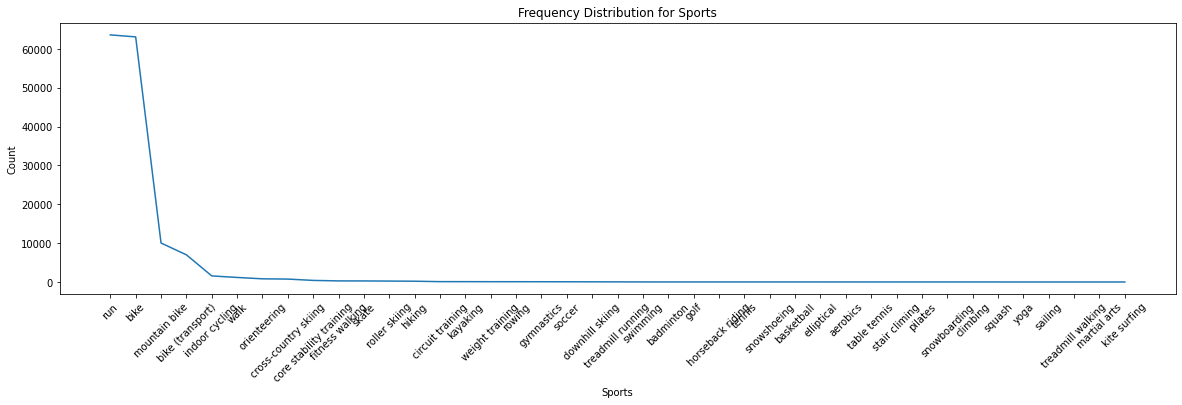

In [116]:
# 2. Sport Categories -- Frequency Distribution
dfcount = dfcount.toPandas()
dfcount = dfcount.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(20,5))
_ = plt.plot(dfcount['sport'], dfcount['count'])
_ = plt.xticks(rotation = 45)
plt.xlabel('Sports')
plt.ylabel('Count')
plt.title('Frequency Distribution for Sports')

In [8]:
# 3. Gender
dfgender = dfhr.groupBy("gender").count()
dfgender

gender,count
unknown,906
female,9537
male,139554


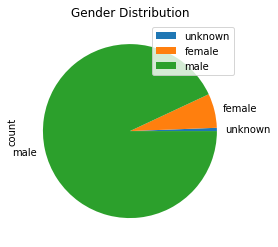

In [117]:
# Plot gender distribution
pdgender = dfgender.toPandas()
pdgender = pdgender.set_index('gender')
pdgender.plot.pie(y='count', title='Gender Distribution')

In [20]:
# Gendere vs Sport
dfinter = dfhr.groupBy("sport", "gender").count().toPandas()
dfinter.loc[dfinter['gender'] == 'male'].sort_values('count',ascending = False).head(10)
dfinter.loc[dfinter['gender'] == 'female'].sort_values('count',ascending = False).head(10)
dfmale = dfinter.loc[dfinter['gender'] == 'male']
dffemale = dfinter.loc[dfinter['gender'] == 'female']
print(dfmale.shape)
print(dffemale.shape)

(41, 3)
(22, 3)


In [21]:
# 4. Unique userId
dfuser = dfhr.groupBy("userId").count()
dfuser = dfuser.sort(col("count"))
print(dfuser.count())
dfuser.tail(10)

100317


[Row(userId='13303518', count=539),
 Row(userId='890789', count=559),
 Row(userId='5641621', count=572),
 Row(userId='791908', count=615),
 Row(userId='8276277', count=646),
 Row(userId='14066832', count=770),
 Row(userId='2486861', count=782),
 Row(userId='4997910', count=821),
 Row(userId='804068', count=1003),
 Row(userId='1063624', count=1261)]

## EndomondoMeta 

- The dataset contains 899991 rows and 4 columns
- Only `hydration` has 92707 missing entries

- `weather`
  - There are total of 35 distinct weather type
  - The frequency of the occurance of each weather type is unevenly distributed, and highler right skewed
- `humidity`
  - The mean humidity is 70.65 and standard deviation is 19.45
  - The range is 1 - 100
  - The distribution is left skewed and reach the peak at around 90
- `wind_direction`
  - The mean wind_direction is 7.37 and standard deviation is 4.65
  - The range is 0 - 15
  - The distribution is quite random with noise peaks and trough
- `temperature`
  - The mean temperature is 13.48 and standard deviation is 8.8
  - The range is -27 - 46
  - The distribution is relatively normal centered around 13
- `wind_speed`
  - The mean wind_speed is 14.18 and standard deviation is 9.06
  - The range is 0 - 242
  - The distribution is higher right skewed with the majority of data concentrated within 0 - 50


In [27]:
# Endomondo Meta Files
meta1 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/1.csv")
meta2 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/2.csv")
meta3 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/3.csv")
meta4 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/4.csv")
meta5 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/5.csv")
meta6 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/6.csv")
meta7 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/7.csv")
meta8 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/8.csv")
meta9 = spark.read.option("header","true").csv("/content/gdrive/MyDrive/9.csv")
dfmeta = meta1.union(meta2).union(meta3).union(meta4).union(meta5).union(meta6).union(meta7).union(meta8).union(meta9)
print((dfmeta.count(), len(dfmeta.columns)))

(899991, 4)


In [28]:
dfmeta

_c0,weather,id,hydration
0,{'type': 7},322483826,null
1,{'type': 7},322483840,null
2,{'type': 6},322483848,null
3,{'type': 1},322483865,null
4,{'type': 1},322483880,null
5,{'type': 6},322483888,null
6,{'type': 3},322483891,null
7,{'type': 11},322483910,null
8,{'type': 1},322483939,null
9,null,322483942,null


In [50]:
# reformat weather column such that 'type', 'humidity', 'wind_direction', 'temperature' and 'wind_speed' would have separate columns
dfmeta = dfmeta.withColumn("weather", from_json(col("weather"), MapType(StringType(), StringType())))

# remove null values in dataframe
dfmeta_cleaned = a.withColumn("type",a.weather.getItem("type")) \
  .withColumn('humidity',a.weather.getItem('humidity')) \
  .withColumn('wind_direction',a.weather.getItem('wind_direction')) \
  .withColumn('temperature',a.weather.getItem('temperature')) \
    .withColumn('wind_speed',a.weather.getItem('wind_speed')) \
  .drop("weather").na.drop(subset=['type','humidity','wind_direction','temperature','wind_speed']) 
dfmeta_cleaned.show()

+----+---------+---------+----+--------+--------------+-----------+----------+
| _c0|       id|hydration|type|humidity|wind_direction|temperature|wind_speed|
+----+---------+---------+----+--------+--------------+-----------+----------+
|8523|347450729|     null|  12|      88|             0|         10|         7|
|8524|347450725|     null|   3|      81|            14|         13|        14|
|8525|347452200|     null|   6|      81|            15|         12|        11|
|8526|347452198|     null|   4|      61|             0|         13|         1|
|8528|340648008|     null|   7|      77|             8|         20|         7|
|8529|340648020|     null|   7|      68|             9|         14|        14|
|8530|340648002|     null|   7|      66|             1|          7|        23|
|8532|339099545|     null|   6|      23|             1|         16|         7|
|8533|339099590|     null|   4|      73|            14|          5|         9|
|8534|339099628|     null|   7|      76|            

In [105]:
# 1. Overall missingness
dfmeta_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfmeta_cleaned.columns]).show()

+---+---+---------+----+--------+--------------+-----------+----------+
|_c0| id|hydration|type|humidity|wind_direction|temperature|wind_speed|
+---+---+---------+----+--------+--------------+-----------+----------+
|  0|  0|    92707|   0|       0|             0|          0|         0|
+---+---+---------+----+--------+--------------+-----------+----------+



In [55]:
# 2. weather type -- Unique Type
metatype = dfmeta_cleaned.groupBy("type").count()
metatype = metatype.sort(col("count"))
print('Number of unique weather type: '+ str(metatype.count()))

Number of unique weather type: 35


Text(0.5, 1.0, 'Weather Type Distribution')

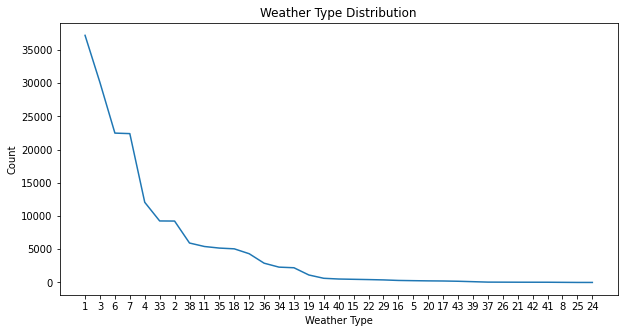

In [118]:
# 2. weather type -- Frequency Distribution
import matplotlib.pyplot as plt
pdtype = metatype.toPandas()
pdtype['type'] = pdtype['type'].astype('category')
pdtype = pdtype.sort_values(by=['count'],ascending=False)
plt.figure(figsize=(10,5))
plt.plot(pdtype['type'], pdtype['count'])
plt.xlabel('Weather Type')
plt.ylabel('Count')
plt.title('Weather Type Distribution')

Mean humididty is 70.65 and standard deviation is 19.45
The range is 1 - 100


Text(0.5, 1.0, 'Humidity Distribution')

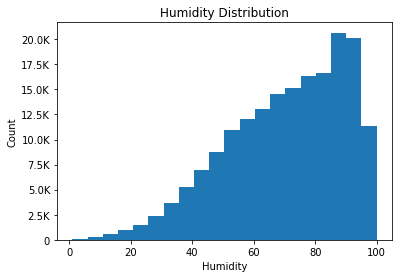

In [129]:
# 3. humidity

## calculate general statistics
dfmeta_cleaned = dfmeta_cleaned.withColumn("humidity", dfmeta_cleaned["humidity"].cast(IntegerType()))
hum_stats = dfmeta_cleaned.select(
    _mean(col('humidity')).alias('mean'),
    _stddev(col('humidity')).alias('std'),
    _max(col('humidity')).alias('max'), 
    _min(col('humidity')).alias('min')
).collect()

mean = hum_stats[0]['mean']
std = hum_stats[0]['std']
print('Mean humididty is '+ str(round(mean,2))+' and standard deviation is '+ str(round(std,2)))
maxi = hum_stats[0]['max']
mini = hum_stats[0]['min']
print('The range is '+ str(mini)+' - '+ str(maxi))

# plot histogram
fig, ax = plt.subplots()
hist(ax, dfmeta_cleaned.select('humidity'), bins = 20)
ax.set_xlabel('Humidity')
ax.set_ylabel('Count')
ax.set_title('Humidity Distribution')

Mean wind_direction is 7.37 and standard deviation is 4.65
The range is 0 - 15


Text(0.5, 1.0, 'Wind Direction Distribution')

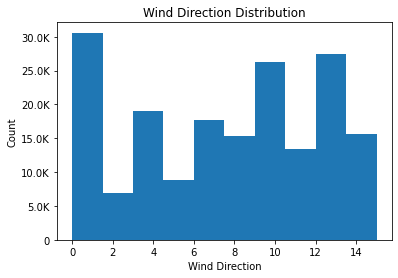

In [130]:
# 4. wind_direction

## calculate general statistics
dfmeta_cleaned = dfmeta_cleaned.withColumn("wind_direction", dfmeta_cleaned["wind_direction"].cast(IntegerType()))
hum_stats = dfmeta_cleaned.select(
    _mean(col('wind_direction')).alias('mean'),
    _stddev(col('wind_direction')).alias('std'),
    _max(col('wind_direction')).alias('max'), 
    _min(col('wind_direction')).alias('min')
).collect()

mean = hum_stats[0]['mean']
std = hum_stats[0]['std']
print('Mean wind_direction is '+ str(round(mean,2))+' and standard deviation is '+ str(round(std,2)))
maxi = hum_stats[0]['max']
mini = hum_stats[0]['min']
print('The range is '+ str(mini)+' - '+ str(maxi))

# plot histogram
fig, ax = plt.subplots()
hist(ax, dfmeta_cleaned.select('wind_direction'), bins = 10)
ax.set_xlabel('Wind Direction')
ax.set_ylabel('Count')
ax.set_title('Wind Direction Distribution')

Mean temperature is 13.48 and standard deviation is 8.8
The range is -27 - 46


Text(0.5, 1.0, 'Temperature Distribution')

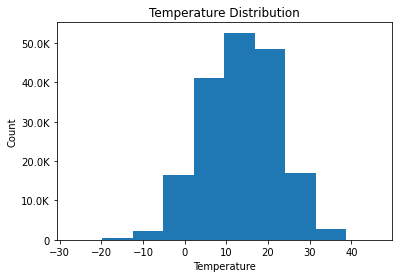

In [128]:
# 5. temperature

## calculate general statistics
dfmeta_cleaned = dfmeta_cleaned.withColumn("temperature", dfmeta_cleaned["temperature"].cast(IntegerType()))
hum_stats = dfmeta_cleaned.select(
    _mean(col('temperature')).alias('mean'),
    _stddev(col('temperature')).alias('std'), 
    _max(col('temperature')).alias('max'), 
    _min(col('temperature')).alias('min')
).collect()

mean = hum_stats[0]['mean']
std = hum_stats[0]['std']
maxi = hum_stats[0]['max']
mini = hum_stats[0]['min']
print('Mean temperature is '+ str(round(mean,2))+' and standard deviation is '+ str(round(std,2)))
print('The range is '+ str(mini)+' - '+ str(maxi))

# plot histogram
fig, ax = plt.subplots()
hist(ax, dfmeta_cleaned.select('temperature'), bins = 10)
ax.set_xlabel('Temperature')
ax.set_ylabel('Count')
ax.set_title('Temperature Distribution')

Mean wind_speed is 14.18 and standard deviation is 9.06
The range is 0 - 242


Text(0.5, 1.0, 'Wind Speed Distribution')

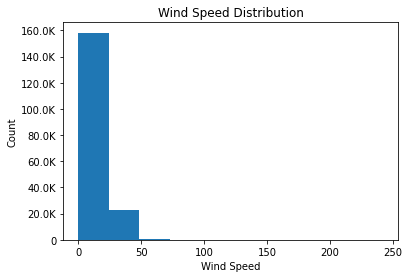

In [131]:
# 6. wind_speed

## calculate general statistics
dfmeta_cleaned = dfmeta_cleaned.withColumn("wind_speed", dfmeta_cleaned["wind_speed"].cast(IntegerType()))
hum_stats = dfmeta_cleaned.select(
    _mean(col('wind_speed')).alias('mean'),
    _stddev(col('wind_speed')).alias('std'), 
    _max(col('wind_speed')).alias('max'), 
    _min(col('wind_speed')).alias('min')
).collect()

mean = hum_stats[0]['mean']
std = hum_stats[0]['std']
maxi = hum_stats[0]['max']
mini = hum_stats[0]['min']
print('Mean wind_speed is '+ str(round(mean,2))+' and standard deviation is '+ str(round(std,2)))
print('The range is '+ str(mini)+' - '+ str(maxi))

# plot histogram
fig, ax = plt.subplots()
hist(ax, dfmeta_cleaned.select('wind_speed'), bins = 5)
ax.set_xlabel('Wind Speed')
ax.set_ylabel('Count')
ax.set_title('Wind Speed Distribution')

# Correlation Between Variables

In [141]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType

df_corr = dfmeta_cleaned.drop('_c0').drop('id').drop('hydration').drop('type')

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(df_corr).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [140]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        , -0.02388729, -0.44229542, -0.08470432, -0.02388729,
        1.        , -0.02034318,  0.28573683, -0.44229542, -0.02034318,
        1.        , -0.09387922, -0.08470432,  0.28573683, -0.09387922,
        1.        ])